# Ali Flu Project 10x - B cells from Blood Samples from P04, P05 and P11 (Year 1 and Year 2) without integration
* Hailong

In [1]:
## load libraries ####
rm(list=ls())
start_time <- Sys.time()
suppressPackageStartupMessages(library("dplyr"))
suppressPackageStartupMessages(library("ggplot2"))
suppressPackageStartupMessages(library("Seurat"))
suppressPackageStartupMessages(library("cowplot"))
suppressPackageStartupMessages(library("pheatmap"))
suppressPackageStartupMessages(library("RColorBrewer"))
suppressPackageStartupMessages(library("Matrix"))
suppressPackageStartupMessages(library("alakazam"))
suppressPackageStartupMessages(library("tidyr"))
suppressPackageStartupMessages(library("gridExtra"))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("scales"))
sampleCat = "Blood"
path.work = file.path("D:","Storage","Ali","10x", "Year2", "GEX", sampleCat)
path.data = file.path("C:","Project","workspace", "AliFlu","10x", "data")
setwd(path.work)
feature.cols = c("lightgray", "blue")

# Load mappings
mapping.file = file.path(path.data, "data_mapping", "map_GEX.txt")
mappings = read.delim(mapping.file, stringsAsFactors = FALSE, as.is=T)
mappings = filter(mappings, SampleType == "IgD-BCell" | SampleType == "PBMC" | SampleType == "PBMC-ASC")
dim(mappings)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Warning message:
"package 'cowplot' was built under R version 3.6.1"
Warning message:
"package 'alakazam' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"


[1] 38  8

In [31]:
# Read in immunestates file
immunostates_file <- file.path(path.data, "immunostates.txt")
immunostates <- read.table(immunostates_file,header = TRUE,sep="\t") %>%
    gather("KNOWN", "EXPR", -Gene) %>%
    rename(GENE = Gene) %>%
    mutate(EXPR = log(EXPR))

In [32]:
# load saved meta pulled from Ensembl 93 using biomaRt
load(file.path(path.data, "QC_features_meta.RData"))

# CellRanger will always return the same number of features in the GEX matrix 
# as long as the same 10x reference is used 
# In this case, for the reference I used, it's 33538 features
dim(features_meta)
#[1] 33538     5

# biotypes of features
# The IG_ and TR_ ones are the ones to exclude
table(features_meta[["gene_biotype"]])
 
# get a vector of IG and TR genes 
# do this by subsetting $gene_biotype (as opposed to basing off gene names)
biotypes_excl = unique(features_meta[["gene_biotype"]])[grepl(pattern="^IG_|^TR_", x=unique(features_meta[["gene_biotype"]]))]
remove.genes = features_meta[["external_gene_name"]][features_meta[["gene_biotype"]] %in% biotypes_excl]

[1] 33538     5


      antisense       IG_C_gene IG_C_pseudogene       IG_D_gene       IG_J_gene 
           5497              14               9              37              18 
IG_J_pseudogene       IG_V_gene IG_V_pseudogene         lincRNA  protein_coding 
              3             144             188            7484           19912 
      TR_C_gene       TR_D_gene       TR_J_gene TR_J_pseudogene       TR_V_gene 
              6               4              79               4             106 
TR_V_pseudogene 
             33 

In [33]:
# read in previously generated GEX data and extract only B cells
#immune.combined <- readRDS(file.path(path.work,"Blood.GEX.pre_B.Y1Y2.rds"))
#b_cells = Cells(immune.combined)

In [34]:
immune.combined <- readRDS(file.path(path.work,"Blood.GEX.Y1Y2.rds"))
immune.combined <- subset(immune.combined, 
                        idents = c('0','1','2','3','4','5','6','12','13','14','15','17','18','21','23'))
b_cells = Cells(immune.combined)

## Read in data and apply filters¶

In [35]:
obj_list <- list()
gene_use=c()
for(samplePath in mappings$SamplePath){     
    sample = mappings$SampleName[which(mappings$SamplePath == samplePath)]
    sample2 = mappings$SampleName2[which(mappings$SamplePath == samplePath)]
    sampleType = mappings$SampleType[which(mappings$SamplePath == samplePath)]
    day = mappings$Day[which(mappings$SamplePath == samplePath)]
    subject = mappings$Subject[which(mappings$SamplePath == samplePath)]
    cat(sample, '\n')    
    dir.name.full = paste0(path.data, samplePath,"/outs/filtered_feature_bc_matrix")
    cat(dir.name.full, '\n')
    data <- Read10X(data.dir = dir.name.full)
    obj <- CreateSeuratObject(counts = data, project = sample, min.cells = 5, min.features = 400)
    obj$sampleName <- sample
    obj$sampleName2 <- sample2
    obj$sampleType <- sampleType
    obj$day <- day
    obj$subject <- subject
    obj <- RenameCells(object = obj, add.cell.id = sample)
    
    # Keep only B cells
    cat('There are', length(Cells(obj)), 'cells before filtering\n')     
    obj <- subset(obj, cells = grep(sample, b_cells, value=TRUE))
    cat('There are', length(Cells(obj)), 'cells after filtering\n') 
    
    obj[["percent.mt"]] <- PercentageFeatureSet(object = obj, pattern = "^MT-")
    gene.cutoff.high=7000
    obj <- subset(x = obj, subset = nFeature_RNA > 400 & nFeature_RNA < gene.cutoff.high & percent.mt < 15)
  
    obj <- NormalizeData(object = obj, normalization.method = "LogNormalize", scale.factor = 10000)
    obj_list[[sample]] <- obj
    
}


P04_IgD-BCell_d0_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d0_PBMC-lib1/outs/filtered_feature_bc_matrix 
There are 9574 cells before filtering
There are 9441 cells after filtering
P04_IgD-BCell_d0_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s0_PBMC-lib1/outs/filtered_feature_bc_matrix 
There are 10735 cells before filtering
There are 10599 cells after filtering
P04_IgD-BCell_d12_1_Y1 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WU321-04-d12_PBMC-lib1/outs/filtered_feature_bc_matrix 
There are 10456 cells before filtering
There are 10201 cells after filtering
P04_IgD-BCell_d14_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s14_PBMC-lib1/outs/filtered_feature_bc_matrix 
There are 10249 cells before filtering
There are 9957 cells after filtering
P04_IgD-BCell_d90_1_Y2 
C:/Project/workspace/AliFlu/10x/data/ellebedy_10x_P04/cr_gex/WUs321-04-s90_PBMC-lib1/outs/filtered_feature_bc

## Read in data and apply filters¶

In [36]:
samples = mappings$SampleName
samples.left = samples[-c(1,2)]
immune.combined <- merge(obj_list[[samples[1]]] , obj_list[[samples[2]]])
for(sample in samples.left){
    immune.combined <- merge(immune.combined ,  obj_list[[sample]])
}
# remove obj_list & obj & data to save space
rm(obj)
rm(data)
rm(obj_list)
gc()


used      (Mb)   gc trigger  (Mb)    max used    (Mb)    
Ncells   2466673  131.8     4252555   227.2     4252555    227.2
Vcells 949816215 7246.6 12979758880 99027.8 16178924670 123435.4

## Number of cells in each sample after filtering

In [37]:
cell.count = as.matrix(table(Idents(immune.combined)))
colnames(cell.count) = "Cell Count"
cell.count

Cell Count
P04_IgD-BCell_d0_1_Y1    9441     
P04_IgD-BCell_d0_1_Y2   10599     
P04_IgD-BCell_d12_1_Y1  10201     
P04_IgD-BCell_d120_1_Y1  9638     
P04_IgD-BCell_d14_1_Y2   9957     
P04_IgD-BCell_d90_1_Y2   8853     
P04_PBMC-ASC_d5_1_Y1    14678     
P04_PBMC-ASC_d7_1_Y2    16178     
P05_IgD-BCell_d0_1_Y1    3362     
P05_IgD-BCell_d0_1_Y2    6612     
P05_IgD-BCell_d12_1_Y1   5526     
P05_IgD-BCell_d120_1_Y1  3309     
P05_IgD-BCell_d13_1_Y2   4743     
P05_IgD-BCell_d180_1_Y1  5503     
P05_IgD-BCell_d180_2_Y1  5726     
P05_IgD-BCell_d28_1_Y1   7366     
P05_IgD-BCell_d28_1_Y2   3106     
P05_IgD-BCell_d5_1_Y1    2780     
P05_IgD-BCell_d6_1_Y2    4103     
P05_IgD-BCell_d60_1_Y1   2663     
P05_IgD-BCell_d60_1_Y2   5543     
P05_IgD-BCell_d90_1_Y1   2750     
P05_IgD-BCell_d90_1_Y2   6861     
P05_IgD-BCell_d90_2_Y1   2727     
P05_PBMC_d0_2_Y1          411     
P05_PBMC_d12_2_Y1         368     
P05_PBMC_d120_1_Y1        303     
P05_PBMC_d28_2_Y1         357     
P05_PBMC_d5_2_Y1          454     
P05_PBMC_d60_1_Y1         245     
P11_IgD-BCell_d0_1_Y1    7147     
P11_IgD-BCell_d0_1_Y2    5997     
P11_IgD-BCell_d120_1_Y1  7771     
P11_IgD-BCell_d35_1_Y1   7133     
P11_IgD-BCell_d35_1_Y2   6389     
P11_IgD-BCell_d90_1_Y2   6526     
P11_PBMC-ASC_d6_1_Y1     7525     
P11_PBMC-ASC_d6_1_Y2     6383

After remvoing IG/TR genes, total gene count is:  1762 


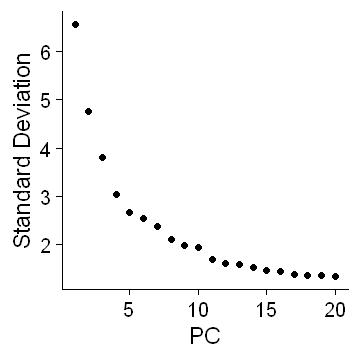

In [38]:
# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(object = immune.combined, verbose = FALSE)
immune.combined <- FindVariableFeatures(immune.combined, selection.method = "vst", nfeatures = 2000, do.plot = F)
bool.remove.genes <- immune.combined@assays$RNA@var.features %in% remove.genes
immune.combined@assays$RNA@var.features = immune.combined@assays$RNA@var.features[!bool.remove.genes]                     
cat('After remvoing IG/TR genes, total gene count is: ', length(immune.combined@assays$RNA@var.features), '\n')
immune.combined <- RunPCA(object = immune.combined, npcs = 30, verbose = FALSE)
options(repr.plot.width=3, repr.plot.height=3)
ElbowPlot(object = immune.combined)

In [39]:
# UMAP and Clustering
immune.combined <- RunUMAP(object = immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(object = immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined, resolution = 0.2)
if(0){immune.combined$sampleName = factor(immune.combined$sampleName, 
        levels = c('P04_IgD-BCell_0_Y1', 'P04_IgD-BCell_12_Y1', 'P04_IgD-BCell_120_Y1', 
                    'P04_PBMC-ASC_5_Y1',
                   
                    'P05_IgD-BCell_0_Y1','P05_IgD-BCell_5_Y1','P05_IgD-BCell_12_Y1','P05_IgD-BCell_28_Y1',
                    'P05_IgD-BCell_60_Y1','P05_IgD-BCell_90_Y1','P05_IgD-BCell_2_90_Y1','P05_IgD-BCell_120_Y1',
                    'P05_IgD-BCell_180_Y1','P05_IgD-BCell_2_180_Y1',
                    'P05_PBMC_2_0_Y1','P05_PBMC_2_5_Y1','P05_PBMC_2_12_Y1','P05_PBMC_2_28_Y1',
                    'P05_PBMC_60_Y1','P05_PBMC_120_Y1',
                  
                    'P11_IgD-BCell_0_Y1','P11_IgD-BCell_35_Y1','P11_IgD-BCell_120_Y1',
                    'P11_PBMC-ASC_6_Y1') )
immune.combined$sampleName2 = factor(immune.combined$sampleName2, 
        levels = c('P04_IgD-BCell_0_Y1', 'P04_IgD-BCell_12_Y1', 'P04_IgD-BCell_120_Y1', 
                    'P04_PBMC-ASC_5_Y1',
                  
                    'P05_IgD-BCell_0_Y1','P05_IgD-BCell_5_Y1','P05_IgD-BCell_12_Y1','P05_IgD-BCell_28_Y1',
                    'P05_IgD-BCell_60_Y1','P05_IgD-BCell_90_Y1','P05_IgD-BCell_120_Y1','P05_IgD-BCell_180_Y1',

                    'P05_PBMC_0_Y1','P05_PBMC_5_Y1','P05_PBMC_12_Y1',
                    'P05_PBMC_28_Y1', 'P05_PBMC_60_Y1','P05_PBMC_120_Y1',
                   
                    'P11_IgD-BCell_0_Y1','P11_IgD-BCell_35_Y1','P11_IgD-BCell_120_Y1',
                    'P11_PBMC-ASC_6_Y1'
                  ) )
      }

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 219234
Number of edges: 5305290

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9472
Number of communities: 15
Elapsed time: 128 seconds


3 singletons identified. 12 final clusters.



In [40]:
object.size(immune.combined)
#str(immune.combined)

41141943696 bytes

In [41]:
#options(repr.plot.width=6, repr.plot.height=3.5)
# visualize results of CCA plot CC1 versus CC2 and look at a violin plot
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleName")

In [42]:
#options(repr.plot.width=6, repr.plot.height=5)
#DimPlot(object = immune.combined, reduction = "umap", group.by = "sampleType", split.by="sampleType")

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


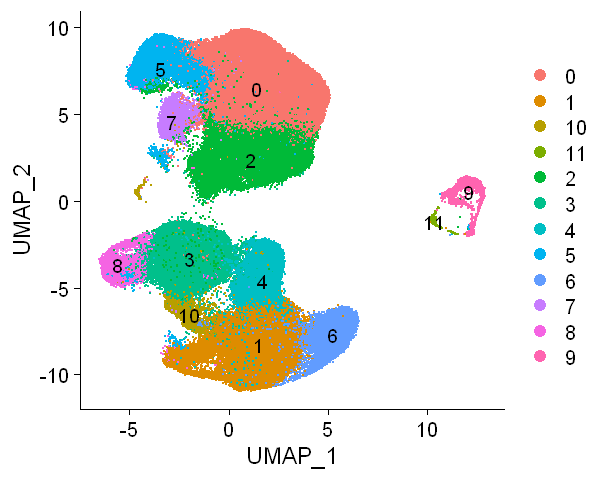

In [43]:
options(repr.plot.width=5, repr.plot.height=4)
DimPlot(object = immune.combined, reduction = "umap", label = TRUE)

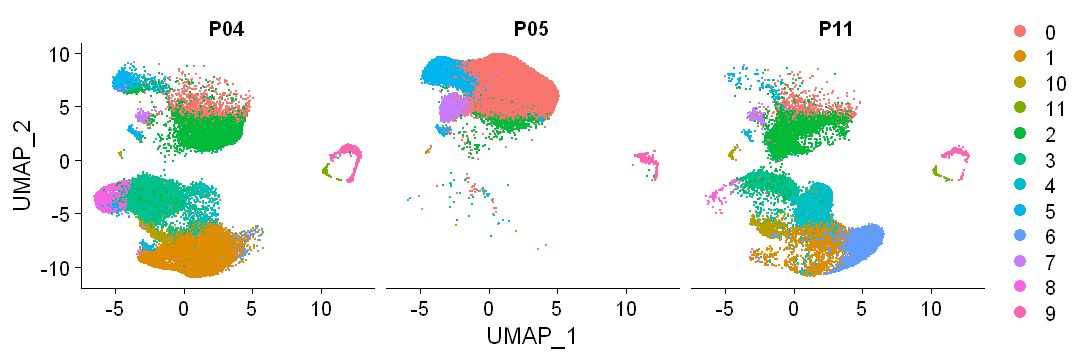

In [44]:
options(repr.plot.width=9, repr.plot.height=3)
DimPlot(object = immune.combined, reduction = "umap", split.by = "subject")

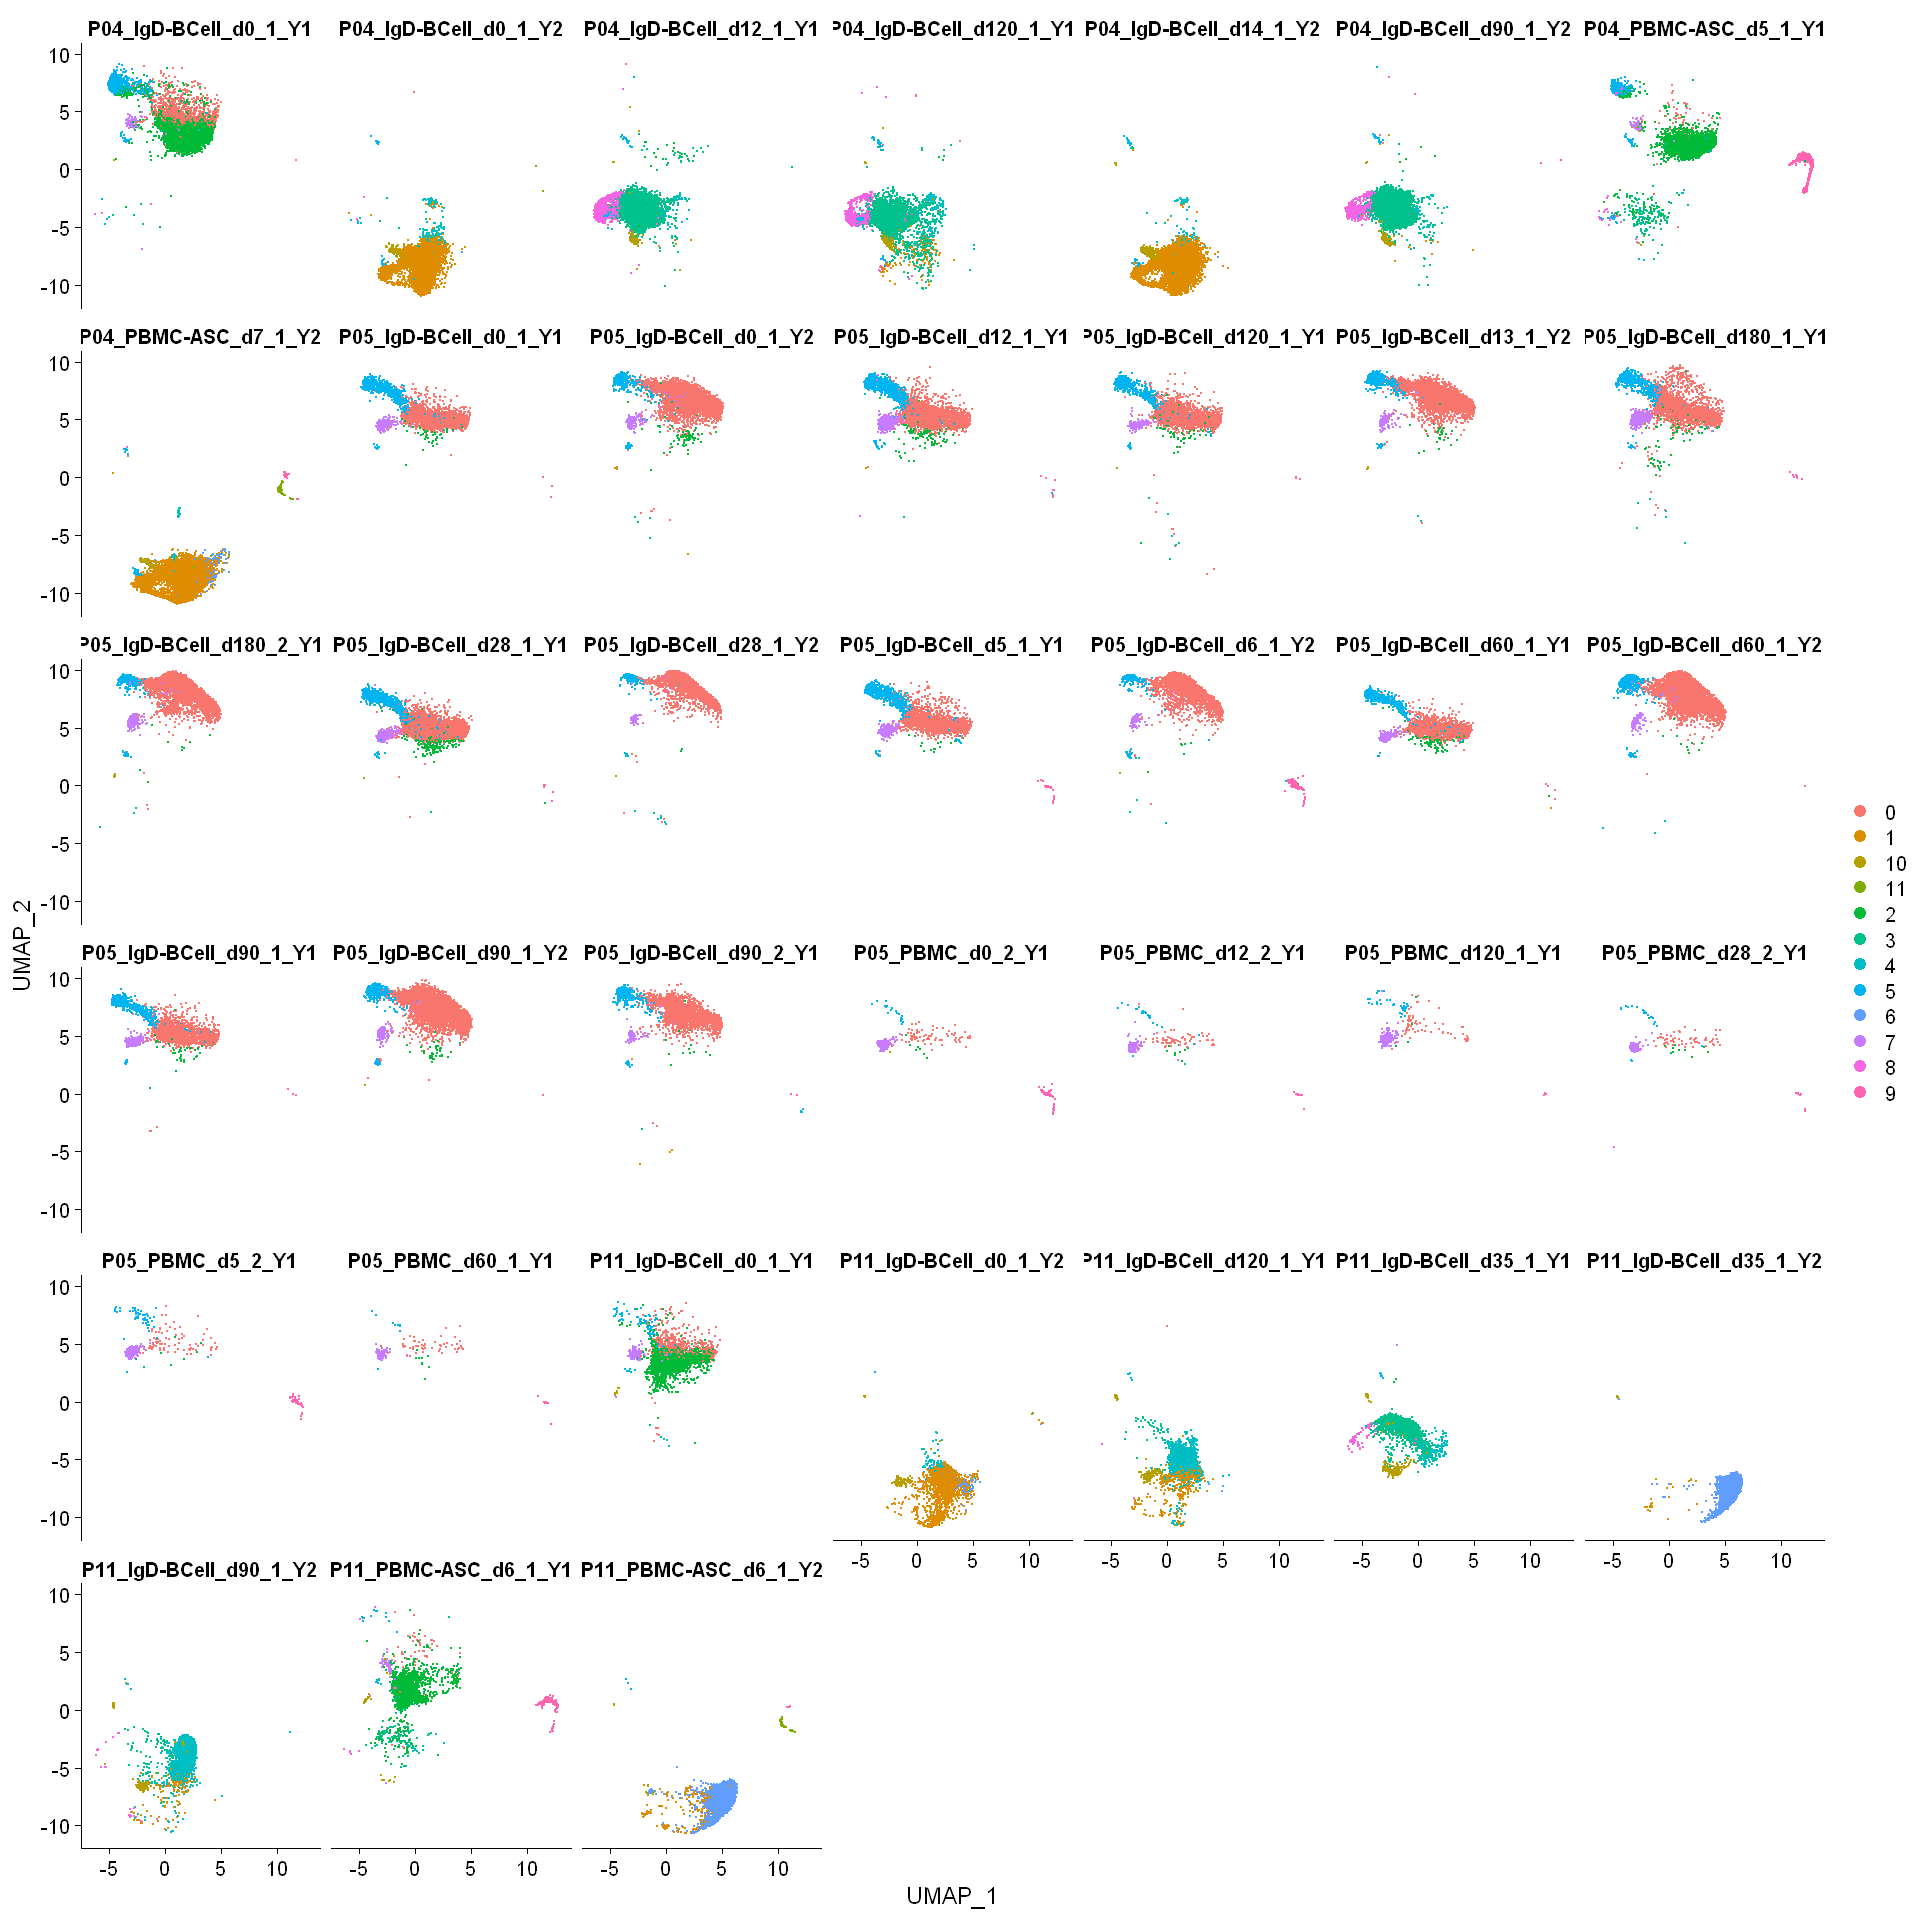

In [63]:
options(repr.plot.width=16, repr.plot.height=16)
DimPlot(object = immune.combined, reduction = "umap", split.by = "sampleName")

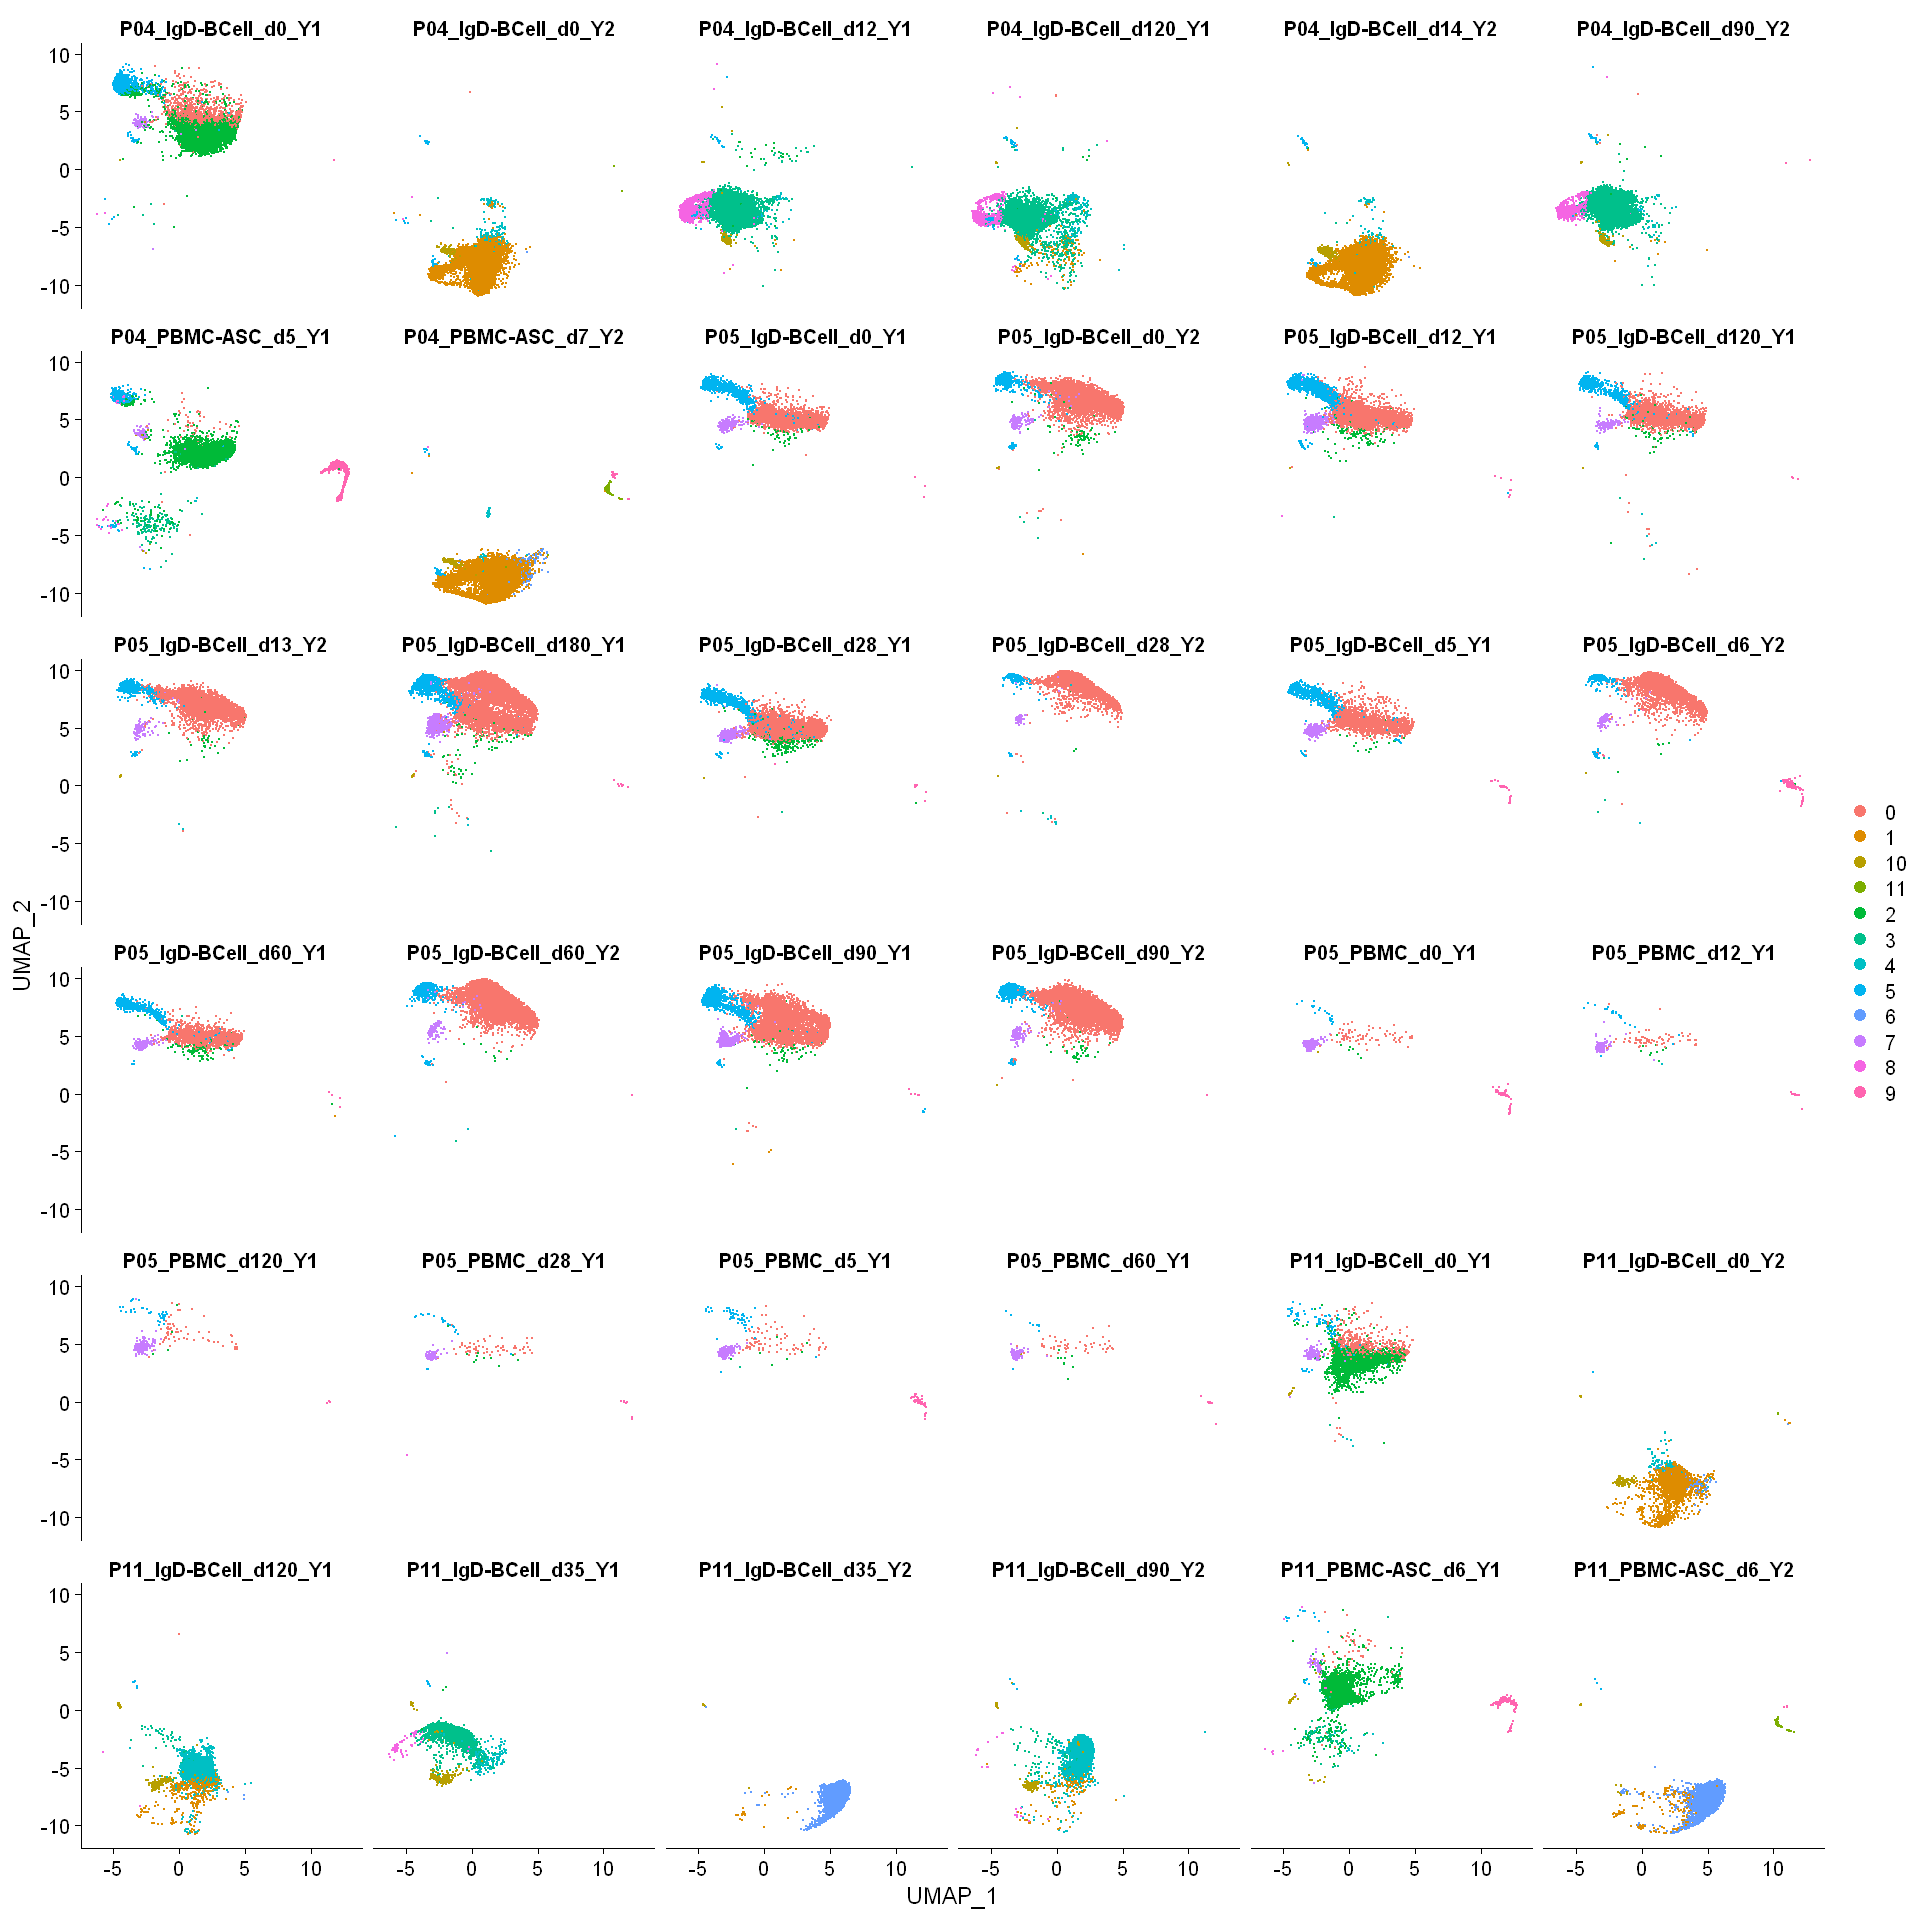

In [64]:
options(repr.plot.width=16, repr.plot.height=16)
DimPlot(object = immune.combined, reduction = "umap", split.by = "sampleName2")

## Check marker genes

In [47]:
B <- c("MS4A1", "IGKC","CD79A", "CD79B", "CD19")
RMB <- c("TNFRSF13B", "CD27", "CD24") #Resting Memory B
naive.B <- c("TCL1A", "IL4R",  "CCR7", "IGHM", "IGHD") #Naive B
plasma <- c("CD38", "CD27","FKBP11","TRIB1","SDC1","XBP1", "IRF4", "SEC11C", "JCHAIN", "PRDM1")
GC.B <- c("BCL6", "RGS13", "MEF2B", "STMN1", "ELL3", "SERPINA9")
ABC <- c("TBX21", "FCRL5", "ITGAX", "NKG7", "ZEB2", "CR2")# the lack of CR2 for activated B cells (ABCs);
T <- c("CD3D", "CD3E","CD4", "IL7R", "CD8A")
NK <- c("GZMB", "GNLY", "NKG7", "NCAM1")
CD14.Monocyte <-c("CD14","LYZ")
DC <- c("FCER1A", "CST3")
platlet <- "PPBP"
dividing  <- c("MKI67", "CDK1") # Dividing cells 
  
all.markers = unique(c(B, RMB, naive.B, plasma, GC.B, ABC, T, NK, CD14.Monocyte, DC, platlet, dividing))
            

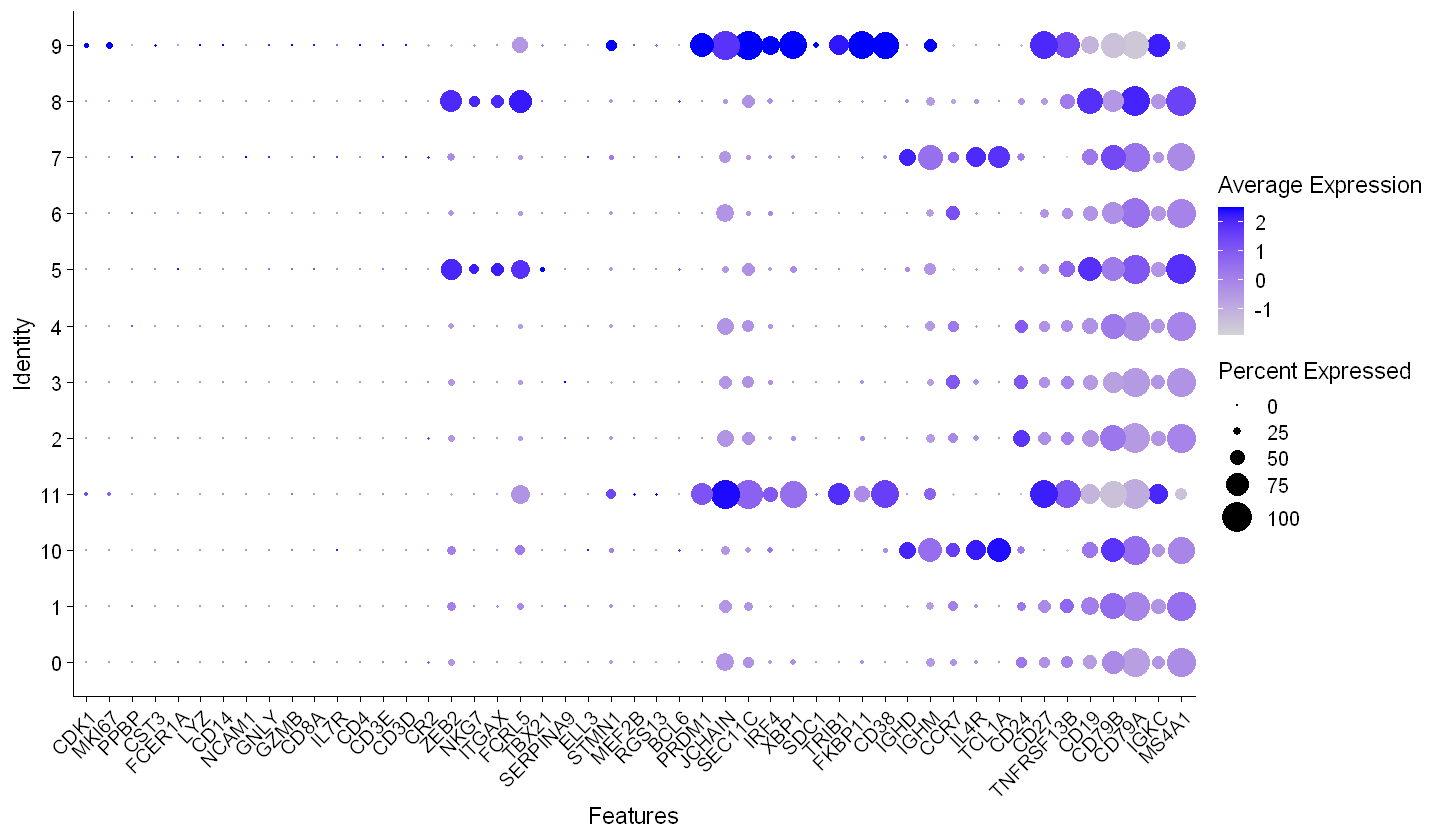

In [48]:
options(repr.plot.width=12, repr.plot.height=7)
DotPlot(immune.combined, assay = "RNA", features =  unique(all.markers), dot.scale = 8) + RotatedAxis()

### B cell markers

options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Plasma markers

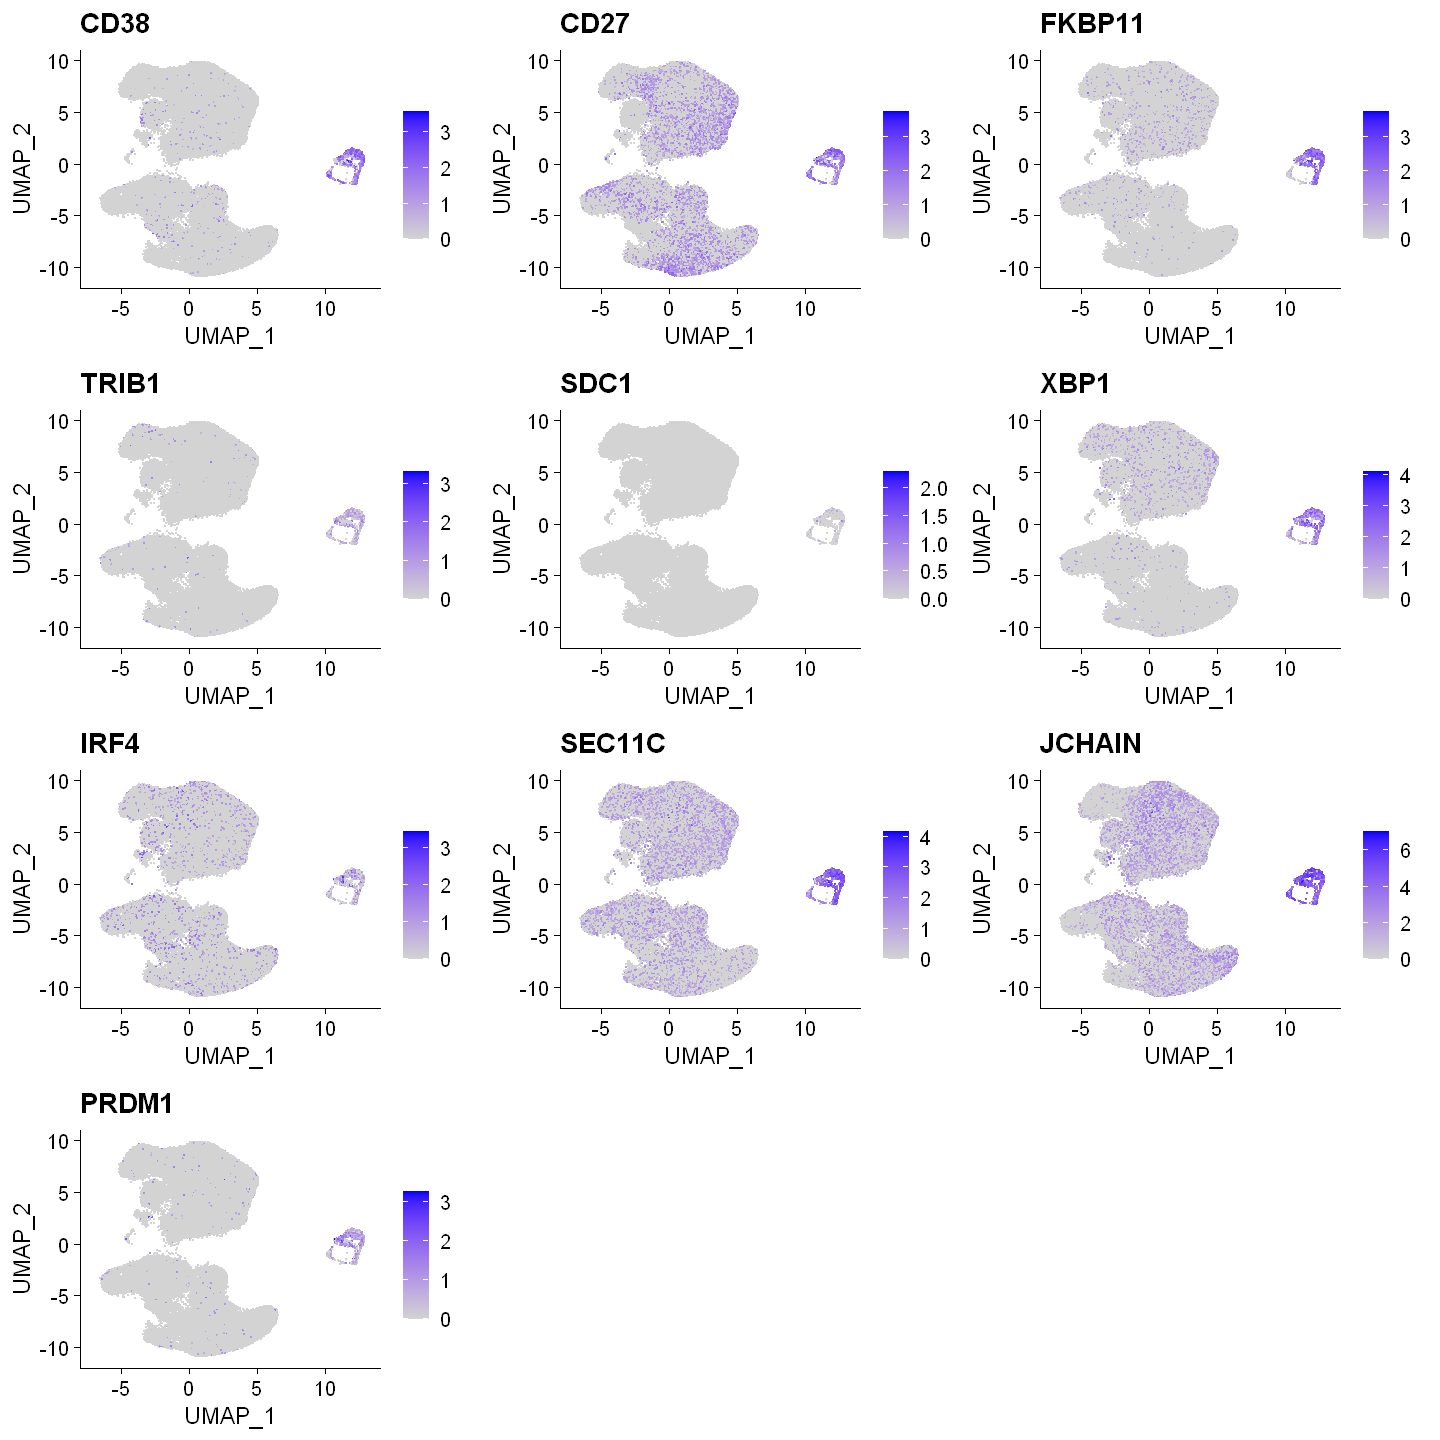

In [50]:
options(repr.plot.width=12, repr.plot.height=12)
FeaturePlot(object = immune.combined, features = plasma, ncol =3,cols = feature.cols, min.cutoff = 0)

### Resting Memory B cells

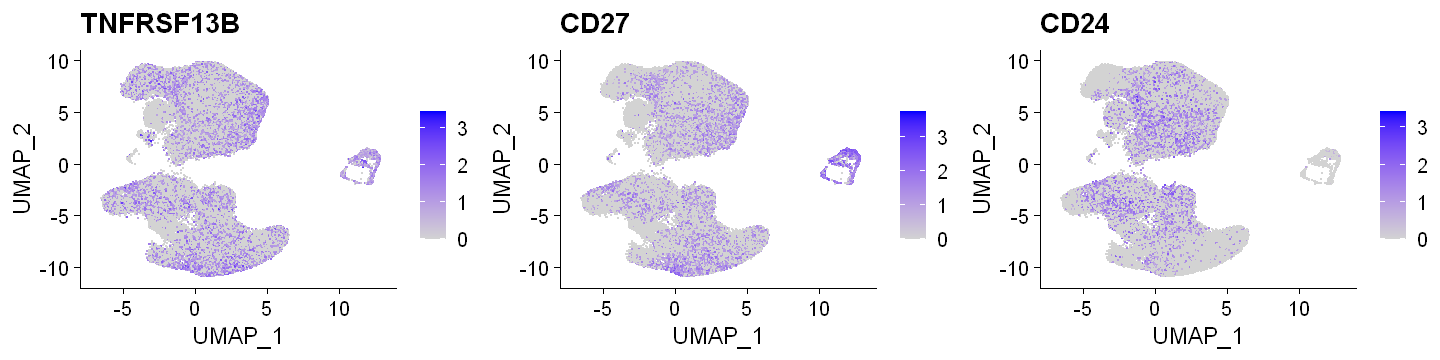

In [51]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = RMB, ncol =3,cols = feature.cols, min.cutoff = 0)

### Naive B cells

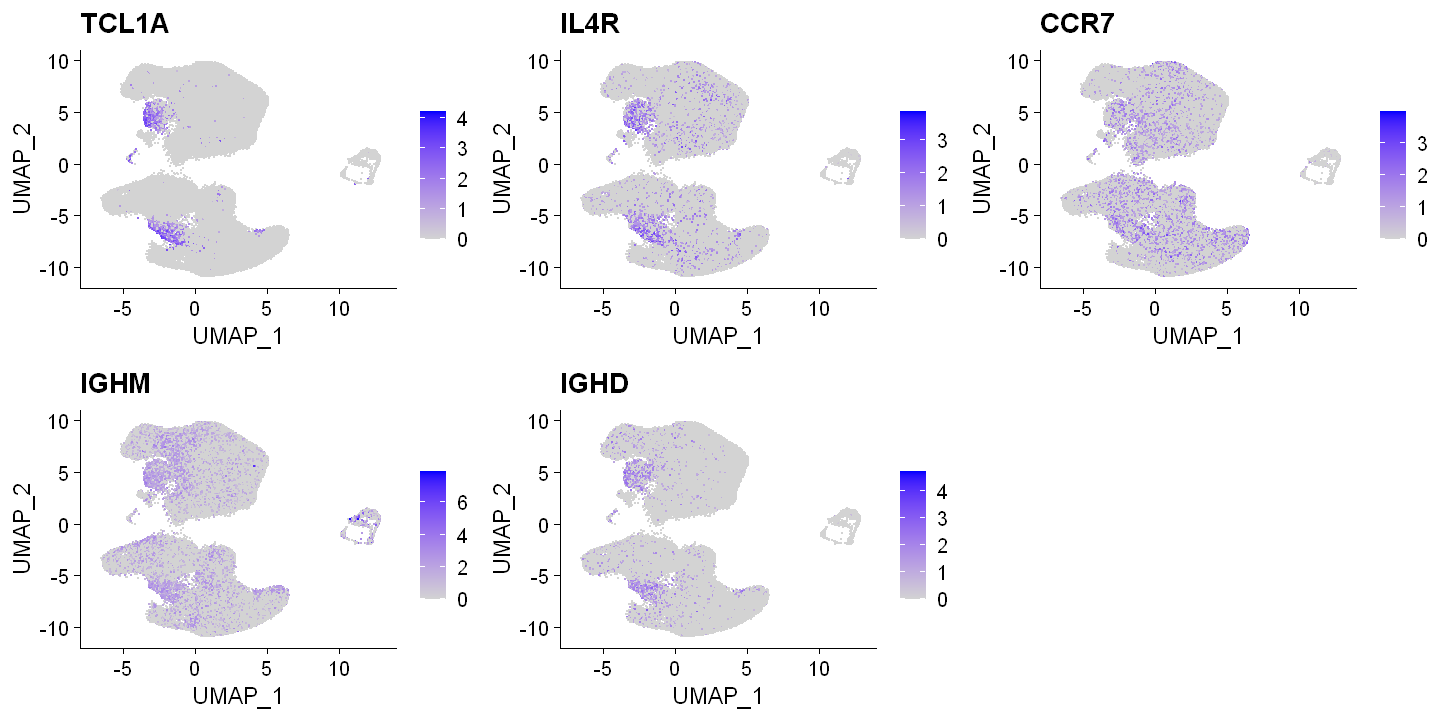

In [52]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = naive.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Germinal Center B cells

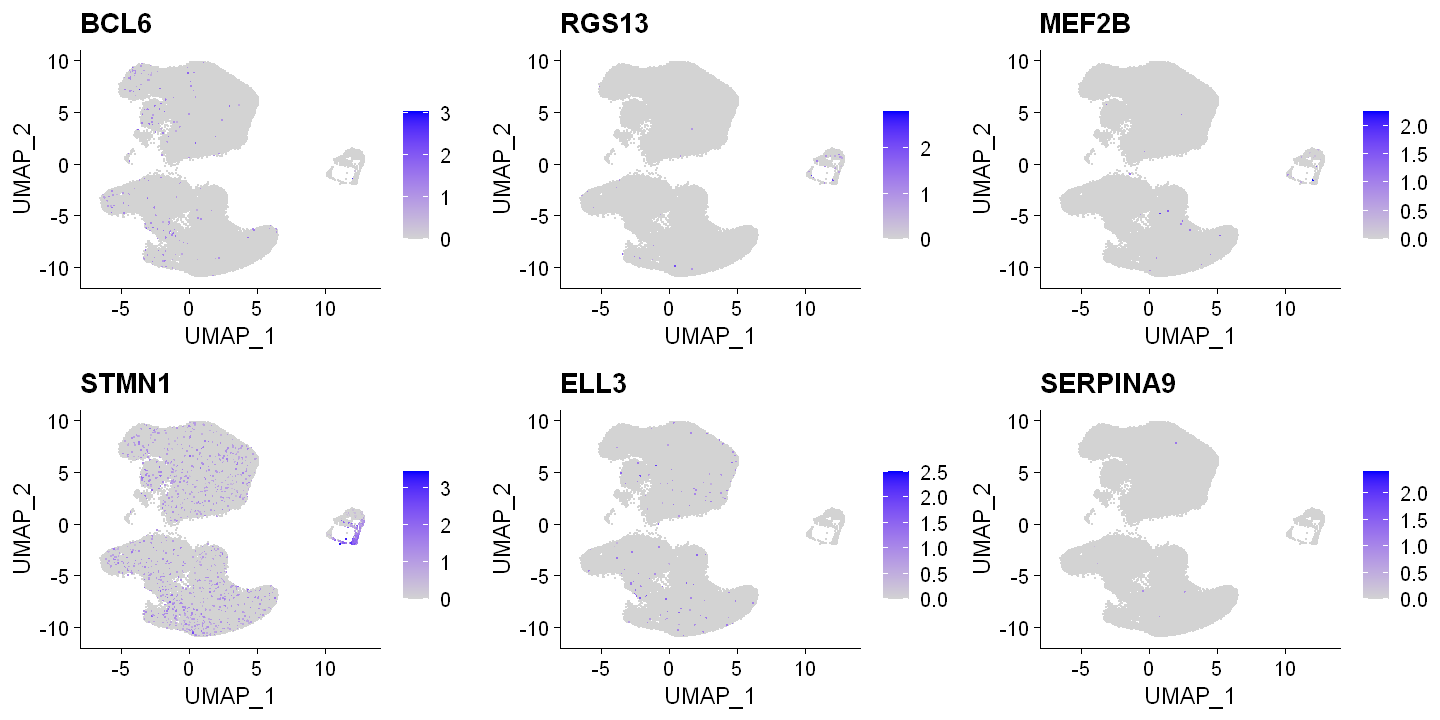

In [53]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = GC.B, ncol =3,cols = feature.cols, min.cutoff = 0)

### Activated B cells

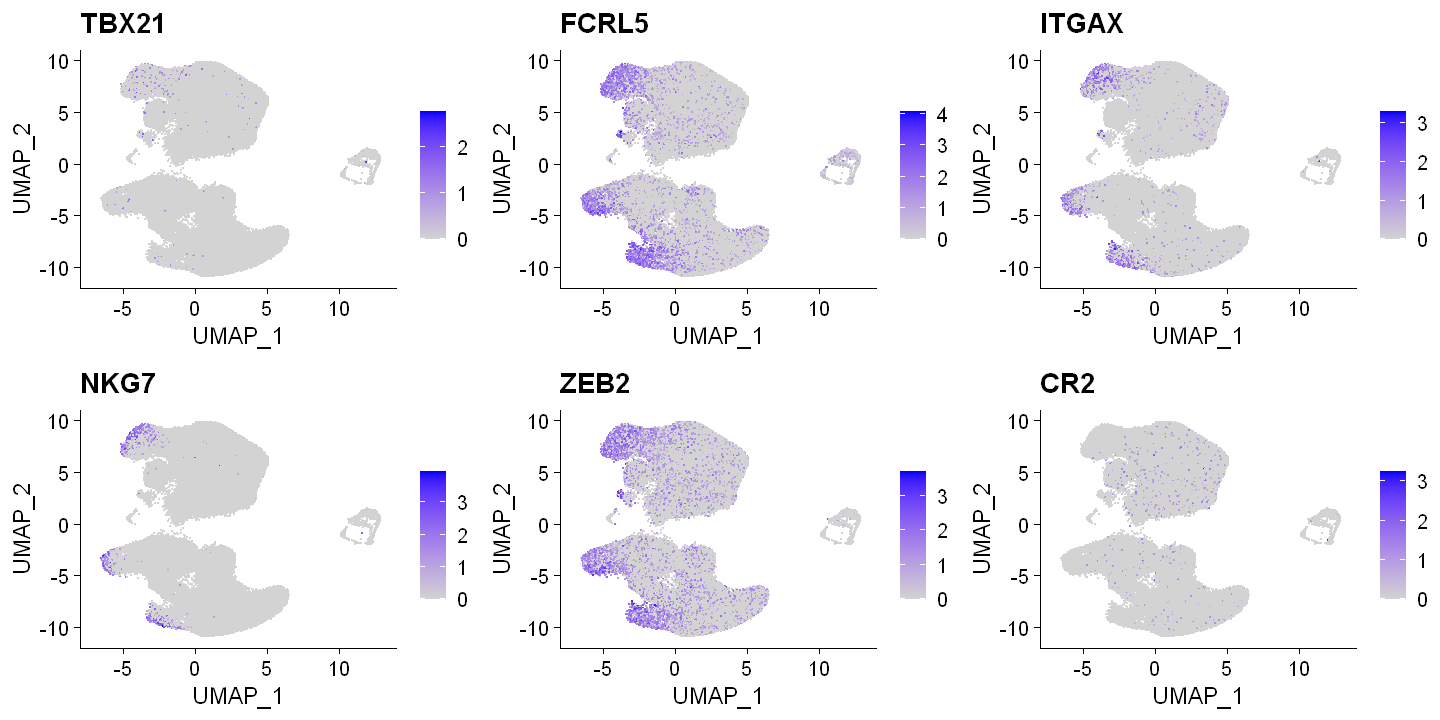

In [54]:
options(repr.plot.width=12, repr.plot.height=6)
FeaturePlot(object = immune.combined, features = ABC, ncol =3,cols = feature.cols, min.cutoff = 0)

### T cell markers

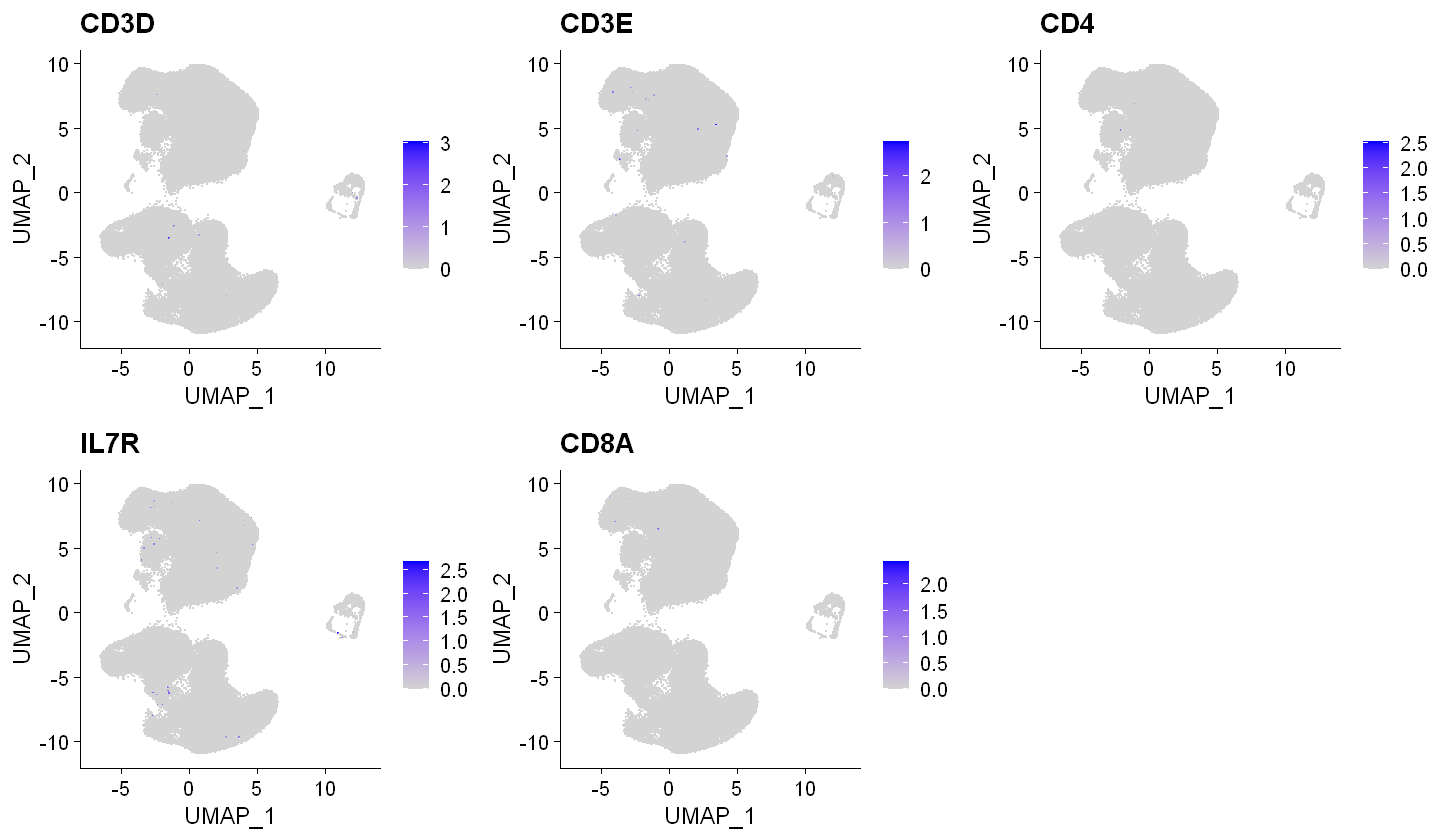

In [55]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = T, ncol =3,cols = feature.cols, min.cutoff = 0)

### NK cell markers

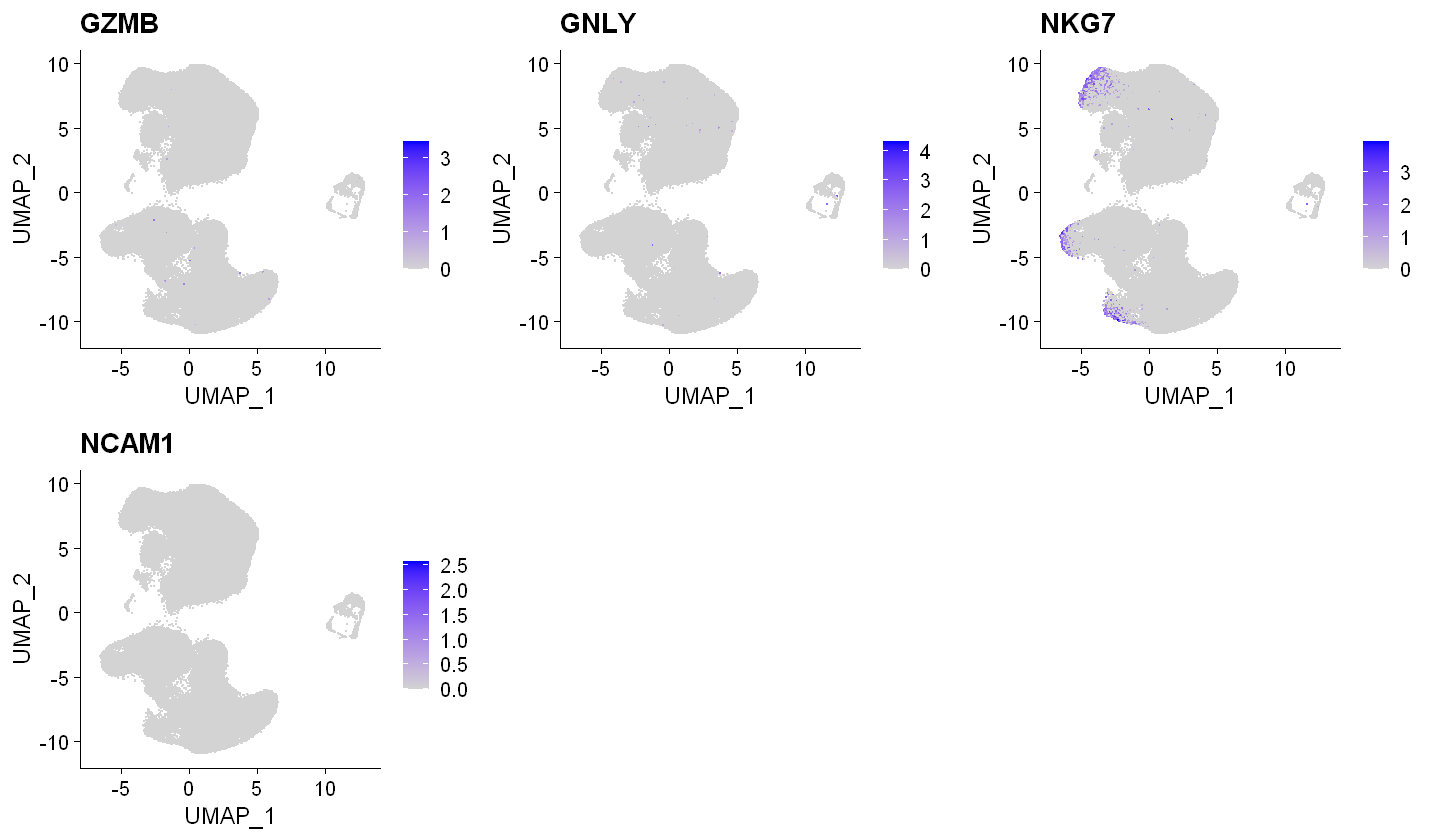

In [56]:
options(repr.plot.width=12, repr.plot.height=7)
FeaturePlot(object = immune.combined, features = NK, ncol =3,cols = feature.cols, min.cutoff = 0)

### DC cell markers

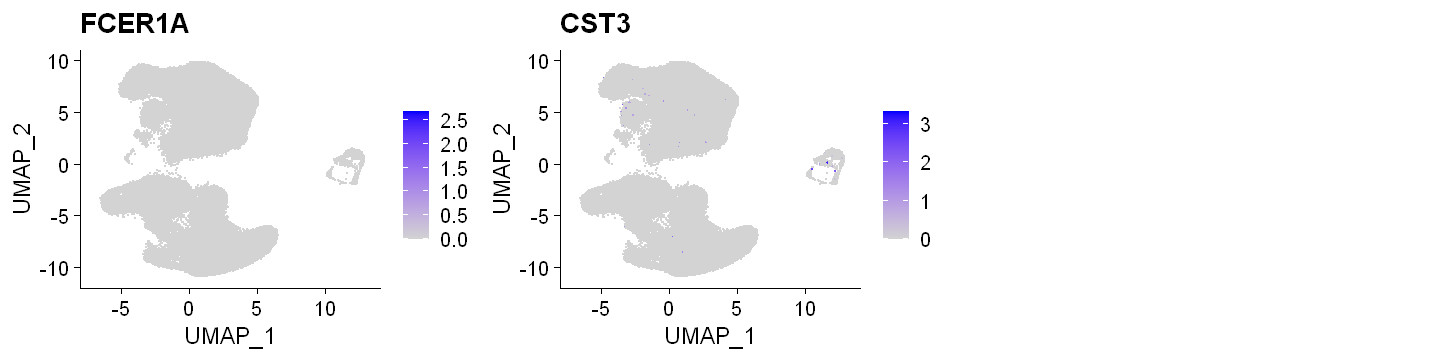

In [57]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = DC, ncol =3,cols = feature.cols, min.cutoff = 0)

### CD14 Monocyte

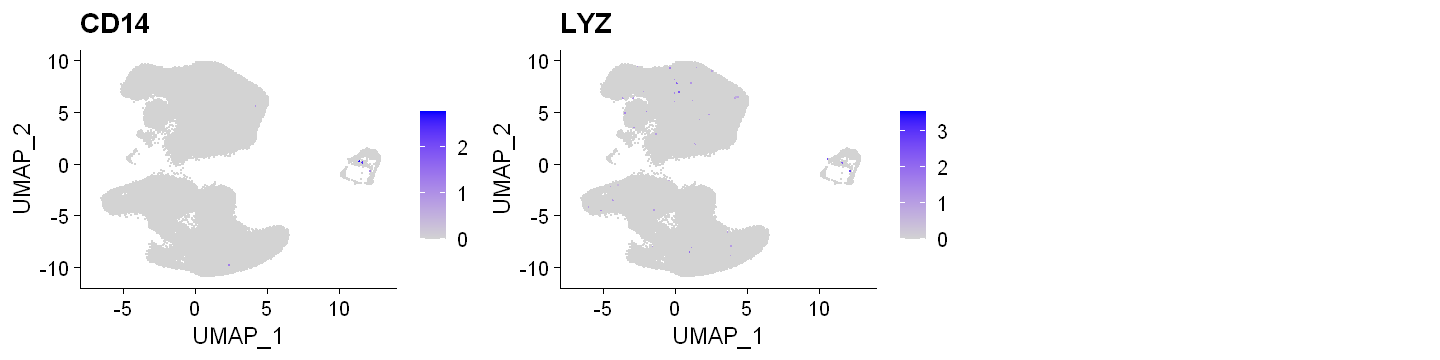

In [58]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = CD14.Monocyte, ncol =3,cols = feature.cols, min.cutoff = 0)

### Platlet

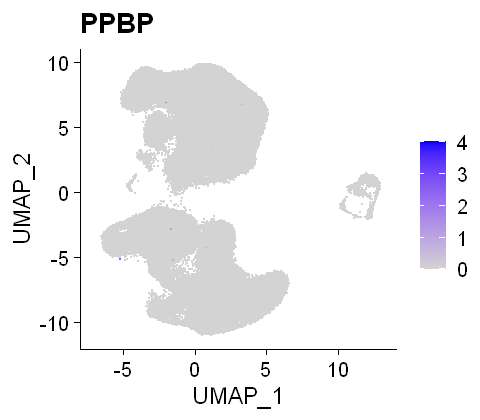

In [59]:
options(repr.plot.width=4, repr.plot.height=3.5)
FeaturePlot(object = immune.combined, features = platlet, cols = feature.cols, min.cutoff = 0)
 

### Dividing cells

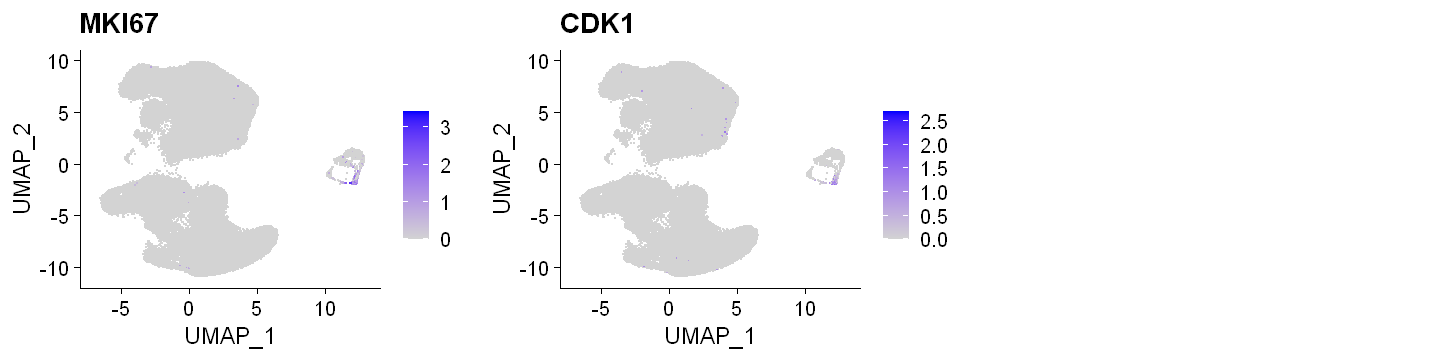

In [60]:
options(repr.plot.width=12, repr.plot.height=3)
FeaturePlot(object = immune.combined, features = dividing, ncol =3,cols = feature.cols, min.cutoff = 0)

# Cell type assignment by Immunostates

In [61]:
identities <- unique(Idents(immune.combined))
assignment_list <- list()
for(identity in identities){
    # mean expression of each gene in each cluster
    identity_cells <- data.frame(IDENTITY = Idents(immune.combined)) %>% 
        tibble::rownames_to_column("CELL") %>%
        filter(IDENTITY == identity) %>% select(CELL) %>% unlist()
    identity_obj <- subset(immune.combined, cells = identity_cells)
    #identity_mean_df <- data.frame(GetAssayData(object = identity_obj, slot = 'scale.data')) %>%
    #identity_mean_df <- data.frame(log(identity_obj@assays$RNA@counts+1) ) %>%
    identity_mean_df <- data.frame(identity_obj@assays$RNA@data) %>% # this data slot has normalized data
        tibble::rownames_to_column("GENE") %>%
        gather("CELL", "EXPR", -GENE) %>% 
        group_by(GENE) %>%
        summarize(EXPR_CLUSTER = mean(EXPR))
    
    # correlations of immunostate vectors with mean gene expression
    assignment_list[[identity]] <- immunostates %>%
        left_join(identity_mean_df, by="GENE") %>%
        drop_na(EXPR_CLUSTER) %>%
        filter(EXPR_CLUSTER != 0) %>%
        group_by(KNOWN) %>%
        summarize(COR = cor(EXPR,EXPR_CLUSTER))
}

ERROR: Error: Internal error in `dict_hash_with()`: Dictionary is full.


In [ ]:
assignment_df <- bind_rows(assignment_list, .id = "IDENTITY") %>% 
    group_by(IDENTITY) %>% 
    filter(COR == max(COR)) %>%
    arrange(as.numeric(IDENTITY))

assignment_df

In [2]:
# save for future use
#saveRDS(immune.combined, file.path(path.work, "Blood_B_beforeAnnotation.GEX.rds"))
immune.combined <- readRDS("Blood_B_beforeAnnotation.GEX.rds")

In [66]:
path.data = file.path("D:","Storage","Ali","10x","Year2","mergeBCR_Y1Y2","data")
BCR.Y1Y2.P04 = read.table(paste0(path.data, "/P04_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)
BCR.Y1Y2.P05 = read.table(paste0(path.data, "/P05_p.tsv"), header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)

BCR.Y1Y2.P04 = BCR.Y1Y2.P04 %>% 
        dplyr::filter((SAMPLETYPE == "IgD-BCell" | SAMPLETYPE == "PBMC" | SAMPLETYPE == "PBMC-ASC")
                      & DATATYPE == "singleCell") 
BCR.Y1Y2.P05 = BCR.Y1Y2.P05 %>% 
        dplyr::filter((SAMPLETYPE == "IgD-BCell" | SAMPLETYPE == "PBMC" | SAMPLETYPE == "PBMC-ASC")
                      & DATATYPE == "singleCell") 
BCR.Y1Y2 = rbind(BCR.Y1Y2.P04, BCR.Y1Y2.P05)

BCR.Y1Y2$CELL = as.character(BCR.Y1Y2$CELL)
BCR.Y1Y2 = BCR.Y1Y2 %>% rowwise() %>%
            mutate(BARCODE = paste(SAMPLE, strsplit(CELL, split = "-")[[1]][1], sep = "_"))

Warning message in read.table(paste0(path.data, "/P04_p.tsv"), header = TRUE, sep = "\t", :
"not all columns named in 'as.is' exist"
Warning message in read.table(paste0(path.data, "/P05_p.tsv"), header = TRUE, sep = "\t", :
"not all columns named in 'as.is' exist"


In [67]:
match.index = match(Cells(immune.combined), BCR.Y1Y2$BARCODE)
immune.combined$contains_bcr = !is.na(match.index)
clone.id = BCR.Y1Y2$CLONE
immune.combined$bcr_clone_id = unlist(lapply(match.index, function(x){ifelse(is.na(x),NA, clone.id[x])}))
mu.freq = BCR.Y1Y2$mu_freq
immune.combined$bcr_mu_freq = unlist(lapply(match.index,function(x){ifelse(is.na(x),NA, mu.freq[x])}))
isotype = as.character(BCR.Y1Y2$ISOTYPE) 
immune.combined$bcr_isotype = unlist(lapply(match.index,function(x){ifelse(is.na(x),NA, isotype[x])}))

In [68]:
length(which(!is.na(match.index)))
umap1 = immune.combined@reductions$umap@cell.embeddings[,1]
umap2 = immune.combined@reductions$umap@cell.embeddings[,2]
GEX.meta = cbind(immune.combined[[]], cbind(umap1,umap2)) %>%
                dplyr::filter(contains_bcr)
colnames(GEX.meta)

[1] 119554

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "sampleName"     
 [5] "sampleName2"     "sampleType"      "day"             "subject"        
 [9] "percent.mt"      "RNA_snn_res.0.2" "seurat_clusters" "contains_bcr"   
[13] "bcr_clone_id"    "bcr_mu_freq"     "bcr_isotype"     "umap1"          
[17] "umap2"

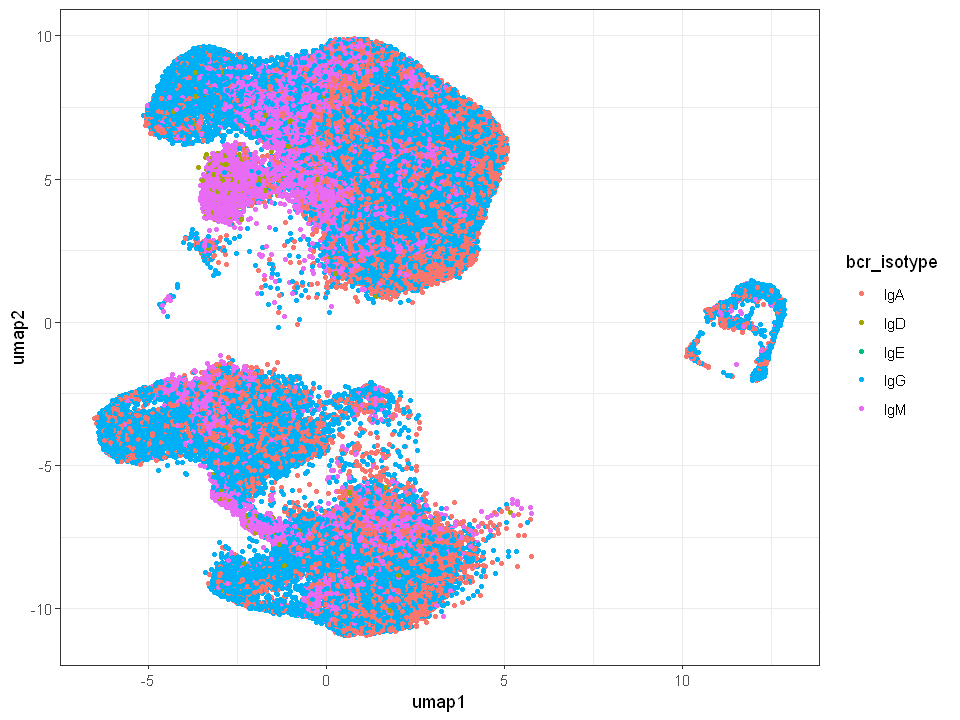

In [69]:
p.a = ggplot()+
    geom_point(data = GEX.meta, aes(x = umap1, y = umap2, color=bcr_isotype), size =1) +theme_bw()
options(repr.plot.width=8, repr.plot.height=6)    
plot(p.a)

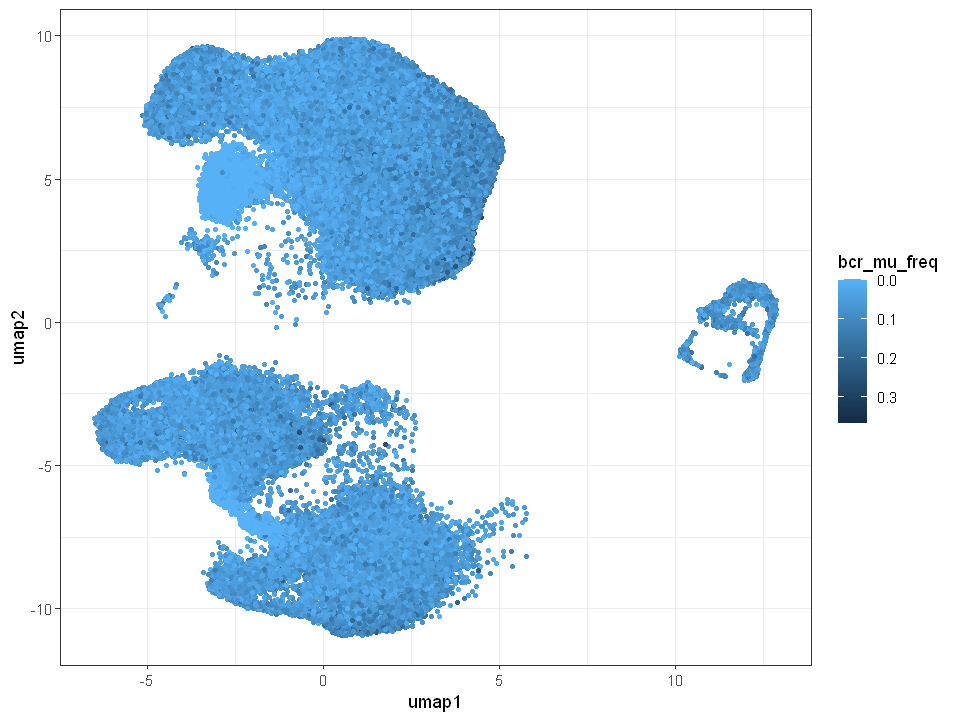

In [70]:
mut.max.freq = max(GEX.meta$bcr_mu_freq) # there is one outlier 0.61
GEX.meta = GEX.meta[-which(GEX.meta$bcr_mu_freq==mut.max.freq),]
p.b = ggplot()+
    geom_point(data = GEX.meta, aes(x = umap1, y = umap2, color=bcr_mu_freq), size =1) +
    theme_bw()+scale_colour_continuous(trans = 'reverse')
plot(p.b)

Warning message:
"Removed 99680 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 99680 rows containing missing values (geom_point)."


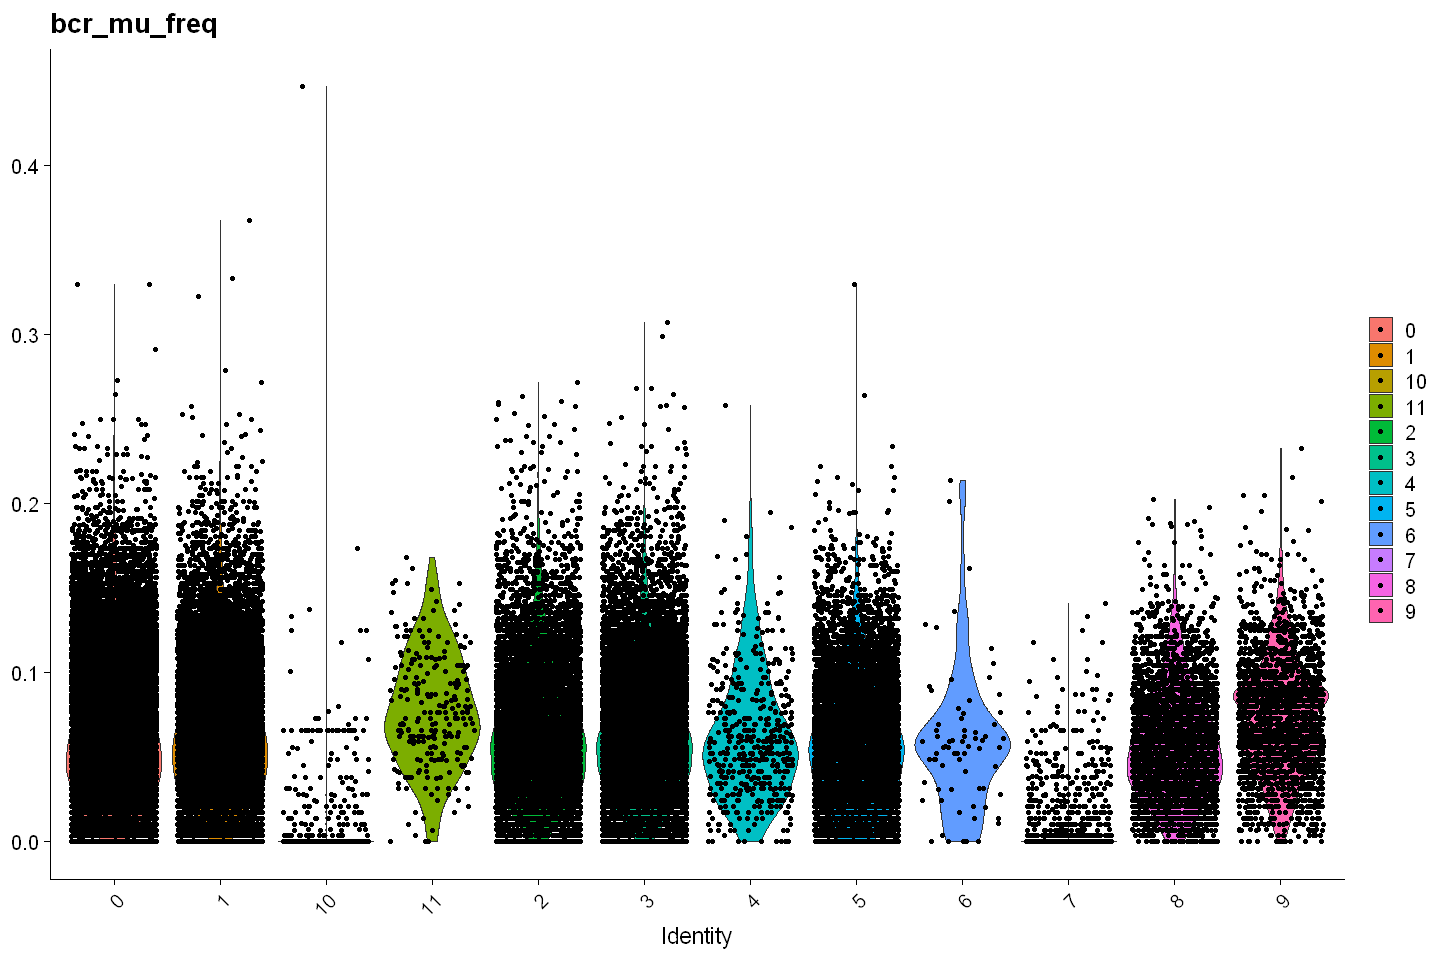

In [71]:
options(repr.plot.width=12, repr.plot.height=8)  
VlnPlot(immune.combined, features =  "bcr_mu_freq")

In [72]:
iso.data = data.frame(Isotype = immune.combined$bcr_isotype, 
                      Cluster=as.character(immune.combined$seurat_clusters),
                      stringsAsFactors = FALSE
                      )
#iso.data = dplyr::filter(iso.data, Cluster %in% c('0','1','2','3','4','5','6','8'))
a <- table(iso.data)
c <- prop.table(a, 1)
c
d <- data.frame(c)

       Cluster
Isotype            0            1           10           11            2
    IgA 0.4001643868 0.2385076029 0.0003816122 0.0033170904 0.1148652616
    IgD 0.0982286634 0.0950080515 0.0982286634 0.0000000000 0.0177133655
    IgE 0.5000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000
    IgG 0.3301232724 0.2222713213 0.0011580599 0.0018894662 0.0952504305
    IgM 0.3578334546 0.1263125065 0.0500051980 0.0004158436 0.0549953218
       Cluster
Isotype            3            4            5            6            7
    IgA 0.1647390360 0.0044032173 0.0338460635 0.0009099982 0.0022309634
    IgD 0.0354267311 0.0032206119 0.0756843800 0.0032206119 0.5636070853
    IgE 0.5000000000 0.0000000000 0.0000000000 0.0000000000 0.0000000000
    IgG 0.1718957137 0.0038398830 0.1018178494 0.0003352279 0.0019808920
    IgM 0.0702775756 0.0032747687 0.1182555359 0.0008316873 0.1985133590
       Cluster
Isotype            8            9
    IgA 0.0211647977 0.0154699701
    IgD 0.0

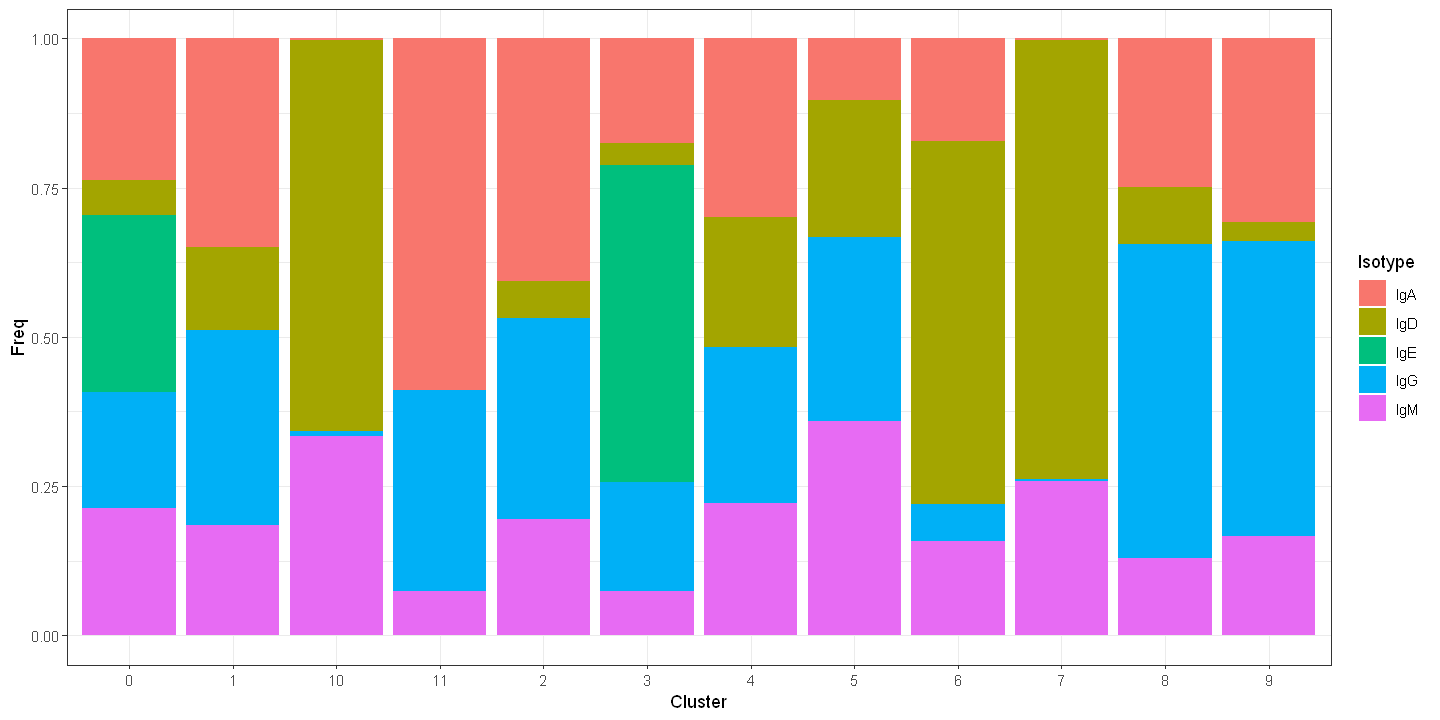

In [73]:
options(repr.plot.width=12, repr.plot.height=6) 
ggplot(d,aes(x = Cluster, y= Freq, fill = Isotype)) + 
  geom_bar(position = "fill", stat = "identity") +
  theme_bw()

In [74]:
levels(x = immune.combined)

[1] "0"  "1"  "10" "11" "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"

In [3]:
#0,1,2,3,4,6: RMB
#7,10: Naive
#5,8: ABC
#9,11:PB
new.cluster.ids <- c("RMB","RMB", "Naive", "PB","RMB", "RMB", # 0,1,10,11,2,3,
                     "RMB", "ABC", "RMB","Naive", "ABC",  "PB"  #4,5,6,7,8,9
                     )
names(x = new.cluster.ids) <- levels(x = immune.combined)

In [4]:
immune.combined <- RenameIdents(object = immune.combined, new.cluster.ids)

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."


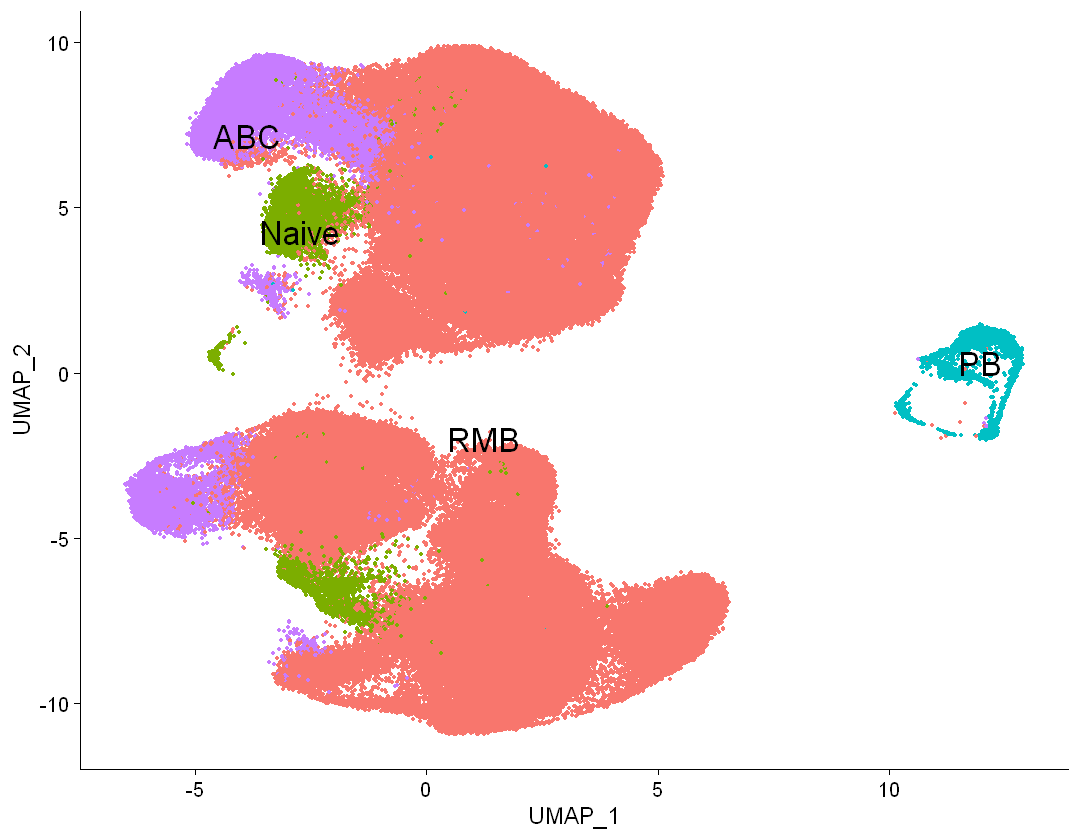

In [5]:
options(repr.plot.width=9, repr.plot.height=7)
DimPlot(object = immune.combined, reduction = "umap", label = TRUE, pt.size = 0.8,label.size=7) + NoLegend()

In [6]:
# save for future use
saveRDS(immune.combined, file.path(path.work, paste0(sampleCat,"_B.GEX.rds")))